# **Compte rendu tp RL**

In this colab we will investigate the **value iteration** and **policy iteration** algorithms in a maze environment.

# Installation #

In [1]:
if get_ipython().__class__.__module__ == "google.colab._shell":
    !apt-get install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [2]:
try:
    import my_gym
except ModuleNotFoundError as e:
    !pip install git+https://github.com/osigaud/my_gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/osigaud/my_gym to /tmp/pip-req-build-uynp0663
  Running command git clone -q https://github.com/osigaud/my_gym /tmp/pip-req-build-uynp0663
     |████████████████████████████████| 1.5 MB 12.4 MB/s 
     |████████████████████████████████| 1.3 MB 53.6 MB/s 
  Created wheel for bbrl-gym: filename=bbrl_gym-0.1.0-py3-none-any.whl size=17222 sha256=88a8d99535f381f7f34b0c1ef02fddfe0d24e5a50a169de1fd0e6ef8bc58bb88
  Stored in directory: /tmp/pip-ephem-wheel-cache-2hbnjgoc/wheels/0b/2c/67/5df37c12451553731420023ff73d12effcae27a38cc5053550
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616828 sha256=c9646f8d9db4ff63200ff748962bd08989073d3458986692c9ab52067a1ecc33
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for mazemdp: filename=mazemdp-0.1.1-py3-none-any.whl size=14721 sha

In [20]:
import os
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from mazemdp.maze_plotter import show_videos
from my_gym.envs.maze_mdp import MazeMDPEnv
from mazemdp.toolbox import egreedy, egreedy_loc, softmax, discreteProb
from mazemdp.mdp import Mdp
# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video

In [5]:
def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    return np.argmax(q, axis=1)

In [6]:
def improve_policy_from_v(mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Improves a policy given the state values
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            v_temp = np.zeros(mdp.action_space.size)
            for u in mdp.action_space.actions:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp[u] = mdp.r[x, u] + mdp.gamma * summ

            for u in mdp.action_space.actions:
                if v_temp[u] > v_temp[policy[x]]:
                    policy[x] = u
    return policy

In [7]:
def evaluate_one_step_v(mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    # Corresponds to one application of the Bellman Operator
    v_new = np.zeros(mdp.nb_states)  # initial state values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            # Process sum of the values of the neighbouring states
            summ = 0
            for y in range(mdp.nb_states):
                summ = summ + mdp.P[x, policy[x], y] * v[y]
            v_new[x] = mdp.r[x, policy[x]] + mdp.gamma * summ
    return v_new


In [35]:
def evaluate_v(mdp: MazeMDPEnv, v: np.ndarray,policy: np.ndarray, K: int=0) -> np.ndarray:
    # Outputs the state value function of a policy
    #v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    stop = False
    cnt = 0
    if  K ==0:
      while not stop:
          vold = v.copy()
          v = evaluate_one_step_v(mdp, vold, policy)
          # Test if convergence has been reached
          cnt += 1
          if (np.linalg.norm(v - vold)) < 0.01:
              stop = True
      print(f"evaluate_one_step appelée {cnt} fois \n")
    else:
      for i in range (K):
        vold = v.copy()
        v = evaluate_one_step_v(mdp, vold, policy)
    return v

In [36]:
# ---------------- Policy Iteration with the V function -----------------#
# Given an MDP, this algorithm simultaneously computes 
# the optimal state value function V and the optimal policy

def generalize_policy_iteration_v(mdp: MazeMDPEnv,k, render: bool = True ) -> Tuple[np.ndarray, List[float]]:
    # policy iteration over the v function
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    policy = random_policy(mdp)
    cnt_policy = 0
    stop = False
    while not stop:

      vold = v.copy()
      if render:
          mdp.init_draw("Policy iteration V")

      
      # Step 1 : Policy Evaluation
      v = evaluate_v(mdp,v, policy,k)
      cnt_policy += 1
      if render:
          mdp.draw_v_pi(v, policy, title="Policy iteration V")

      # Step 2 : Policy Improvement
      policy = improve_policy_from_v(mdp, v, policy)
      v_list.append(np.linalg.norm(v - vold))
      if (np.linalg.norm(v - vold)) < 0.01:
            stop = True

    if render:
        mdp.draw_v_pi(v, policy, title="Policy iteration V")
        mdp.mdp.plotter.video_writer.release()
    print(f"Pour K = {k} evaluate_v a été appelé {cnt_policy} fois \n")
    return v, v_list, cnt_policy


In [11]:
from mazemdp import random_policy

In [37]:
v, v_list , cnt_policy = generalize_policy_iteration_v(env, 100,render=True)

Output()

Pour K = 100 evaluate_v a été appelé 7 fois 



Output()

evaluate_one_step appelée 3 fois 

evaluate_one_step appelée 4 fois 

evaluate_one_step appelée 3 fois 

evaluate_one_step appelée 3 fois 

evaluate_one_step appelée 3 fois 

evaluate_one_step appelée 1 fois 

Pour K = 0 evaluate_v a été appelé 6 fois 

Pour K = 1 evaluate_v a été appelé 9 fois 

Pour K = 2 evaluate_v a été appelé 7 fois 

Pour K = 3 evaluate_v a été appelé 7 fois 

Pour K = 4 evaluate_v a été appelé 6 fois 

Pour K = 5 evaluate_v a été appelé 8 fois 

Pour K = 6 evaluate_v a été appelé 9 fois 

Pour K = 7 evaluate_v a été appelé 6 fois 

Pour K = 8 evaluate_v a été appelé 7 fois 

Pour K = 9 evaluate_v a été appelé 8 fois 



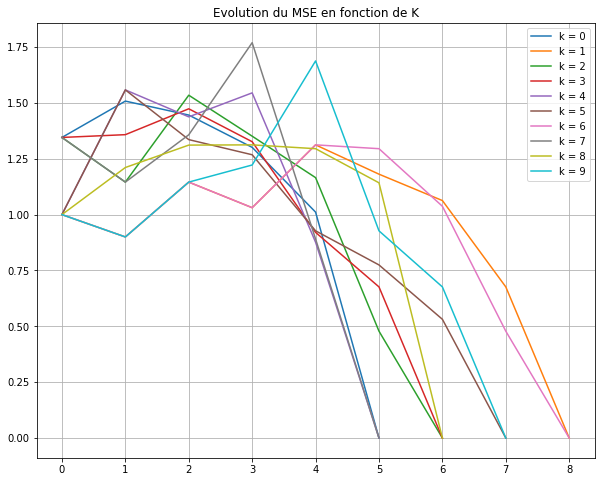

In [38]:
k_list = np.arange(0, 10, 1, dtype="int")
tab_cnt_policy = []
tab_v_list = []
for k in k_list:
  v, v_list , cnt_policy = generalize_policy_iteration_v(env, k,render=True)
  tab_cnt_policy.append(cnt_policy)
  tab_v_list.append(v_list)

plt.figure(figsize=(10, 8))
plt.title("Evolution du MSE en fonction de K")
for i, k in enumerate(k_list):
  plt.plot(range(len(tab_v_list[i])),tab_v_list[i], label=f"k = {k}")

plt.grid()
plt.legend()

Implémentation SARSA softmax

In [22]:
# --------------------------- Sarsa, softmax version -------------------------------#

# Given a temperature "tau", the SARSA algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate
def sarsa_soft(
    mdp: MazeMDPEnv,
    tau: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:

    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Sarsa softmax")

    for _ in tqdm(range(nb_episodes)):
        # Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True)
        u = discreteProb(softmax(q, x, tau))
        done = False

        while not done:

          
          # Perform a step of the MDP
          [y, r, done, _] = mdp.step(u) 
          if render:
            # Show the agent in the maze
            mdp.draw_v_pi(q, q.argmax(axis=1))

          # À compléter...       
          u_ = discreteProb(softmax(q, y, tau))

          delta = r + mdp.gamma * q[y,u_] - q[x,u]
          q[x,u] = q[x,u] + alpha * delta 
          x = y
          u = u_

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q), title="Sarsa softmax")
    return q, q_list


Test de SARSA

In [39]:
tau = 6
NB_EPISODES = 50
TIMEOUT = 25
q, q_list = sarsa_soft(env, tau, nb_episodes=NB_EPISODES)

Output()

  0%|          | 0/50 [00:00<?, ?it/s]

Après avoir tester différentes valeurs de tau on constate que si tau est grand il a plus tendance à explorer et à exploiter dans le cas où tau est petit 